In [1]:
# Step 1 Read in data
# Step 2 Preprocess text data
# Step 3 Word Embedding
# Step 4 LDA

importing packages

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
stop = stopwords.words('english')
import re
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize.treebank import TreebankWordTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from collections import Counter
import gensim
from gensim import corpora, models
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim 

C:\Users\conor\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
yelp=pd.read_csv('all_data20180608.csv')

### PreProcessing
#step 1 lower case
#step 2 punctuation
#step 3 stop word
#step 4 common word removal
#step 5 rare word removal
#step 6 token
#step 7 stemming
#step 8 lemma

In [4]:
#step 1
yelp['lower'] = yelp.text.apply(lambda x: " ".join(x.lower() for x in x.split()))
yelp.lower.head()

0    my friend gabi, i love your cute parisian inte...
1     had a good waiter, all the staff were very cool.
2    my only regret is not catching the name of our...
3    lotus of siam did not disappoint, the service ...
4    his name is carlos if you ever want to request...
Name: lower, dtype: object

In [5]:
# step 2
reg_tok = RegexpTokenizer(r'\w+')#+ is one or more
yelp['no_punc'] = yelp['lower'].apply(lambda x: ' '.join(reg_tok.tokenize(x)))
yelp.no_punc.head()

0    my friend gabi i love your cute parisian inter...
1       had a good waiter all the staff were very cool
2    my only regret is not catching the name of our...
3    lotus of siam did not disappoint the service w...
4    his name is carlos if you ever want to request...
Name: no_punc, dtype: object

In [6]:
# step 3
yelp['no_stop'] = yelp['no_punc'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
yelp.no_stop.head()

0    friend gabi love cute parisian interior dim li...
1                               good waiter staff cool
2    regret catching name server best experienced f...
3        lotus siam disappoint service great attentive
4          name carlos ever want request service great
Name: no_stop, dtype: object

In [7]:
# top most common words
freq = pd.Series(' '.join(yelp['no_stop']).split()).value_counts()[:20]#combining all rows and then splitting and converitign and value count
freq
#looking at these, we actually want to keep them so no need to carry out this step

food          3504
good          1925
buffet        1556
service       1554
great         1365
place         1111
vegas          882
like           764
restaurant     656
one            642
get            641
best           635
really         625
quality        611
price          596
would          552
time           539
go             539
selection      470
better         463
dtype: int64

In [8]:
# least common words
rare = pd.Series(' '.join(yelp['no_stop']).split()).value_counts()[-600:]

In [9]:
rare = list(rare.index)
yelp['no_rare'] = yelp['no_stop'].apply(lambda x: " ".join(x for x in x.split() if x not in rare))

In [10]:
# from textblob import TextBlob
# # not really doing that for tutorial, this is just demo of it
# yelp['no_stop'][:5].apply(lambda x: str(TextBlob(x).correct()))

In [11]:
# step 6
_word_tokenize = TreebankWordTokenizer()
yelp['token'] = yelp['no_rare'].apply(lambda x: ' '.join(_word_tokenize.tokenize(x)))
yelp.token.head()

0    friend gabi love cute parisian interior dim li...
1                               good waiter staff cool
2    regret catching name server best experienced f...
3        lotus siam disappoint service great attentive
4          name carlos ever want request service great
Name: token, dtype: object

In [12]:
# step 7
st = SnowballStemmer("english")
yelp['stemed']=yelp['token'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))
yelp.stemed.head()

0    friend gabi love cute parisian interior dim li...
1                               good waiter staff cool
2    regret catch name server best experienc far tr...
3            lotus siam disappoint servic great attent
4            name carlo ever want request servic great
Name: stemed, dtype: object

In [13]:
#step 8
wordnet_lemmatizer = WordNetLemmatizer()
yelp['lemma']=yelp['stemed'].apply(lambda x: " ".join([wordnet_lemmatizer.lemmatize(word) for word in x.split()]))
yelp.lemma.head(20)

0     friend gabi love cute parisian interior dim li...
1                                good waiter staff cool
2     regret catch name server best experienc far tr...
3             lotus siam disappoint servic great attent
4             name carlo ever want request servic great
5                               room beauti server good
6     servic quick price ok get pretti darn good san...
7                                 good servic good food
8     say locat decor lotus siam never life find bet...
9                              servic snappi food tasti
10    came month ago food ok initi encount cashier g...
11                       hostess waitress friend attent
12                     shout boy wesley host cool peopl
13                                 waitress awesom help
14     servic great busi afternoon outdoor set look day
15    arriv 3pm weekday prompt seat busi patio time ...
16    happi help take mani pictur request alway kept...
17    item order mon ami gabi oyster du jour 15 

In [14]:
yelp.lemma.str.len().max()

600

In [15]:
sentences=yelp['lemma'].tolist()
print(sentences[:5])

['friend gabi love cute parisian interior dim light knowledg waiter delici food', 'good waiter staff cool', 'regret catch name server best experienc far trip vega', 'lotus siam disappoint servic great attent', 'name carlo ever want request servic great']


In [16]:
tkn_sentences = []
for s in sentences:
    sent = _word_tokenize.tokenize(s)
    #print(sent)
    #break
    tkn_sentences.append(sent)

In [17]:
# creating word dictionary
dictionary=[]
for s in tkn_sentences:
    num_free = [x for x in s if not (x.isdigit() or x[0] == '-' and x[1:].isdigit())]
    #print(num_free)
    legit_words = [x for x in num_free if not len(x) < 2]
    dictionary.append(legit_words)

In [18]:
print(dictionary)

[['friend', 'gabi', 'love', 'cute', 'parisian', 'interior', 'dim', 'light', 'knowledg', 'waiter', 'delici', 'food'], ['good', 'waiter', 'staff', 'cool'], ['regret', 'catch', 'name', 'server', 'best', 'experienc', 'far', 'trip', 'vega'], ['lotus', 'siam', 'disappoint', 'servic', 'great', 'attent'], ['name', 'carlo', 'ever', 'want', 'request', 'servic', 'great'], ['room', 'beauti', 'server', 'good'], ['servic', 'quick', 'price', 'ok', 'get', 'pretti', 'darn', 'good', 'sandwich', 'definit', 'back', 'next', 'time', 'vega'], ['good', 'servic', 'good', 'food'], ['say', 'locat', 'decor', 'lotus', 'siam', 'never', 'life', 'find', 'better', 'servic', 'receiv'], ['servic', 'snappi', 'food', 'tasti'], ['came', 'month', 'ago', 'food', 'ok', 'initi', 'encount', 'cashier', 'good', 'one', 'accus', 'cut', 'line', 'tri', 'walk', 'around', 'crowd', 'tri', 'figur', 'payment', 'fast', 'forward', 'month', 'later', 'comp', 'buffet', 'spoke', 'manag', 'verifi', 'comp', 'quit', 'charact', 'mani', 'red', 'bull

In [19]:


#count=Counter(" ".join(dictionary)).items()
print(sorted(count))

NameError: name 'count' is not defined

In [ ]:
#len(count)

In [ ]:
print(max(yelp.lemma, key=len))

convert to word 2 vec
check word to vec model
bring in lda
create lda model
check results

In [20]:
model = gensim.models.Word2Vec(dictionary, sg=1)

In [21]:
print(model.wv['friend'])

[-0.07759484 -0.08224218  0.21830398  0.05222762 -0.01198578  0.30997097
 -0.04946956  0.42570892  0.3019286   0.21461995 -0.13391721 -0.18540655
 -0.3082663   0.26685613  0.04715832  0.37670097 -0.45964414  0.02089559
 -0.12423172  0.06686609 -0.4181845  -0.02191238 -0.26825318 -0.2948008
  0.2560226  -0.23795593  0.04227645 -0.5368911   0.3096481  -0.05247989
 -0.09209762 -0.2081946   0.35705096 -0.0933984  -0.32119736 -0.00647871
 -0.09706981  0.39284518 -0.09018037  0.5245681  -0.01631298 -0.29838926
  0.09187294 -0.11102588  0.00880205 -0.42686677  0.16856776 -0.15644829
  0.22537187  0.10939714 -0.14459236 -0.03983311  0.08113005  0.24339919
 -0.06460354  0.27812833 -0.23278758  0.23075403  0.2747613  -0.31324136
  0.4258784  -0.03889738 -0.28553334 -0.07595047  0.13803245  0.22670512
 -0.02827906 -0.14637132  0.06911392 -0.17595212  0.15565217  0.241626
  0.07595444  0.42582932 -0.0570979  -0.05568631 -0.15250818 -0.25591698
 -0.04733652  0.06520319 -0.25456065 -0.05370338  0.23

In [22]:
model.wv.most_similar(positive='waiter', topn=10)

[('server', 0.9882555603981018),
 ('refil', 0.9725899696350098),
 ('help', 0.9711248874664307),
 ('drink', 0.9657329320907593),
 ('waitress', 0.9597737193107605),
 ('manag', 0.9564347267150879),
 ('ask', 0.9360432624816895),
 ('took', 0.925182580947876),
 ('clear', 0.9244444370269775),
 ('empti', 0.9236732721328735)]

In [23]:
model.wv.most_similar(positive='waitress', topn=10)

[('help', 0.9736813306808472),
 ('prompt', 0.9706646203994751),
 ('refil', 0.970569372177124),
 ('attent', 0.963425874710083),
 ('manag', 0.9600571393966675),
 ('waiter', 0.9597737193107605),
 ('effici', 0.957338809967041),
 ('hostess', 0.9525569677352905),
 ('server', 0.9496443271636963),
 ('glass', 0.9487956762313843)]

In [24]:

# Create Dictionary
id2word = corpora.Dictionary(dictionary)

# Create Corpus
texts = dictionary

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1)]]


In [25]:
id2word[0]

'cute'

In [26]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus]

[[('cute', 1),
  ('delici', 1),
  ('dim', 1),
  ('food', 1),
  ('friend', 1),
  ('gabi', 1),
  ('interior', 1),
  ('knowledg', 1),
  ('light', 1),
  ('love', 1),
  ('parisian', 1),
  ('waiter', 1)],
 [('waiter', 1), ('cool', 1), ('good', 1), ('staff', 1)],
 [('best', 1),
  ('catch', 1),
  ('experienc', 1),
  ('far', 1),
  ('name', 1),
  ('regret', 1),
  ('server', 1),
  ('trip', 1),
  ('vega', 1)],
 [('attent', 1),
  ('disappoint', 1),
  ('great', 1),
  ('lotus', 1),
  ('servic', 1),
  ('siam', 1)],
 [('name', 1),
  ('great', 1),
  ('servic', 1),
  ('carlo', 1),
  ('ever', 1),
  ('request', 1),
  ('want', 1)],
 [('good', 1), ('server', 1), ('beauti', 1), ('room', 1)],
 [('good', 1),
  ('vega', 1),
  ('servic', 1),
  ('back', 1),
  ('darn', 1),
  ('definit', 1),
  ('get', 1),
  ('next', 1),
  ('ok', 1),
  ('pretti', 1),
  ('price', 1),
  ('quick', 1),
  ('sandwich', 1),
  ('time', 1)],
 [('food', 1), ('good', 2), ('servic', 1)],
 [('lotus', 1),
  ('servic', 1),
  ('siam', 1),
  ('better

In [27]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=15, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [28]:
# Print the Keyword in the 10 topics
from pprint import pprint
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.061*"tast" + 0.053*"also" + 0.048*"thing" + 0.036*"dine" + '
  '0.024*"seafood" + 0.023*"meat" + 0.023*"offer" + 0.021*"visit" + '
  '0.021*"lamb" + 0.019*"found"'),
 (1,
  '0.057*"everyth" + 0.056*"wait" + 0.046*"got" + 0.038*"way" + 0.033*"went" + '
  '0.032*"peopl" + 0.030*"mani" + 0.028*"bagel" + 0.028*"die" + '
  '0.028*"garden"'),
 (2,
  '0.054*"fri" + 0.038*"dumpl" + 0.029*"ask" + 0.029*"crispi" + 0.028*"bbq" + '
  '0.027*"beef" + 0.026*"cook" + 0.024*"duck" + 0.022*"plea" + 0.021*"indian"'),
 (3,
  '0.070*"meal" + 0.047*"everi" + 0.032*"need" + 0.032*"ambienc" + 0.031*"bad" '
  '+ 0.029*"seem" + 0.028*"sweet" + 0.025*"attent" + 0.022*"bone" + '
  '0.022*"gem"'),
 (4,
  '0.076*"go" + 0.055*"time" + 0.046*"make" + 0.043*"back" + 0.038*"even" + '
  '0.033*"order" + 0.031*"feel" + 0.025*"serv" + 0.024*"come" + 0.023*"top"'),
 (5,
  '0.189*"good" + 0.044*"buffet" + 0.043*"tri" + 0.038*"fresh" + '
  '0.037*"realli" + 0.037*"would" + 0.036*"one" + 0.033*"qualiti" + '
  '0.03

In [29]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.


# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=dictionary, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.586149233976721

Coherence Score:  0.3848868105573654


In [30]:

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
6      13.925344        1       1  0.433604  0.121427
5      12.755905        1       2  0.088630 -0.425187
4       8.806734        1       3  0.007297 -0.007446
9       7.437891        1       4  0.004302  0.017287
10      7.109578        1       5 -0.023742  0.015595
0       6.393558        1       6 -0.051282  0.028835
8       5.870196        1       7 -0.031099  0.025527
12      5.188381        1       8 -0.034970  0.018839
11      5.122531        1       9 -0.054475  0.027769
13      5.086525        1      10 -0.044245  0.025565
1       5.064774        1      11 -0.063185  0.027817
7       4.974207        1      12 -0.050090  0.021248
2       4.321644        1      13 -0.064469  0.034916
14      4.251341        1      14 -0.049523  0.032382
3       3.691394        1      15 -0.066754  0.035423, topic_info=     Category         Freq       Term        Total  loglift  logprob
term                                                                
3     Default  2892.000000       food  2892.000000  30.0000  30.0000
13    Default  2682.000000       good  2682.000000  29.0000  29.0000
26    Default  1741.000000      great  1741.000000  28.0000  28.0000
28    Default  1677.000000     servic  1677.000000  27.0000  27.0000
275   Default  1263.000000      place  1263.000000  26.0000  26.0000
255   Default   931.000000       like   931.000000  25.0000  25.0000
15    Default   718.000000       best   718.000000  24.0000  24.0000
195   Default   748.000000         go   748.000000  23.0000  23.0000
43    Default   860.000000      price   860.000000  22.0000  22.0000
39    Default   547.000000        get   547.000000  21.0000  21.0000
1053  Default   586.000000      pizza   586.000000  20.0000  20.0000
263   Default   516.000000       nice   516.000000  19.0000  19.0000
222   Default   507.000000       dish   507.000000  18.0000  18.0000
14    Default   470.000000      staff   470.000000  17.0000  17.0000
172   Default   681.000000    restaur   681.000000  16.0000  16.0000
46    Default   542.000000       time   542.000000  15.0000  15.0000
191   Default   412.000000       wine   412.000000  14.0000  14.0000
283   Default   403.000000       amaz   403.000000  13.0000  13.0000
61    Default   618.000000     buffet   618.000000  12.0000  12.0000
90    Default   612.000000        tri   612.000000  11.0000  11.0000
9     Default   433.000000       love   433.000000  10.0000  10.0000
171   Default   437.000000       tast   437.000000   9.0000   9.0000
1     Default   611.000000     delici   611.000000   8.0000   8.0000
223   Default   399.000000        eat   399.000000   7.0000   7.0000
48    Default   388.000000      decor   388.000000   6.0000   6.0000
1055  Default   375.000000      sushi   375.000000   5.0000   5.0000
122   Default   370.000000      alway   370.000000   4.0000   4.0000
216   Default   455.000000       make   455.000000   3.0000   3.0000
439   Default   533.000000      fresh   533.000000   2.0000   2.0000
276   Default   532.000000     realli   532.000000   1.0000   1.0000
...       ...          ...        ...          ...      ...      ...
487   Topic15   193.029844      everi   194.051998   3.2939  -3.0575
199   Topic15   132.559919       need   133.582073   3.2915  -3.4333
770   Topic15   130.465464    ambienc   131.487620   3.2914  -3.4492
350   Topic15   128.459291        bad   129.481445   3.2912  -3.4647
526   Topic15   117.323346       seem   118.345500   3.2905  -3.5554
959   Topic15   113.532265      sweet   114.554419   3.2902  -3.5882
24    Topic15   104.551911     attent   105.574066   3.2894  -3.6706
2494  Topic15    92.146877       bone    93.169035   3.2881  -3.7969
632   Topic15    90.079078        gem    91.101237   3.2879  -3.8196
363   Topic15    85.351311       care    86.373467   3.2873  -3.8735
1841  Topic15    77.731311     potato    78.753465   3.2861  -3.9670
204

In [31]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=1000, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

C:\Users\conor\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
C:\Users\conor\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
C:\Users\conor\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
C:\Users\conor\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
C:\Users\conor\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() ins

C:\Users\conor\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
C:\Users\conor\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
C:\Users\conor\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
C:\Users\conor\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
C:\Users\conor\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() ins

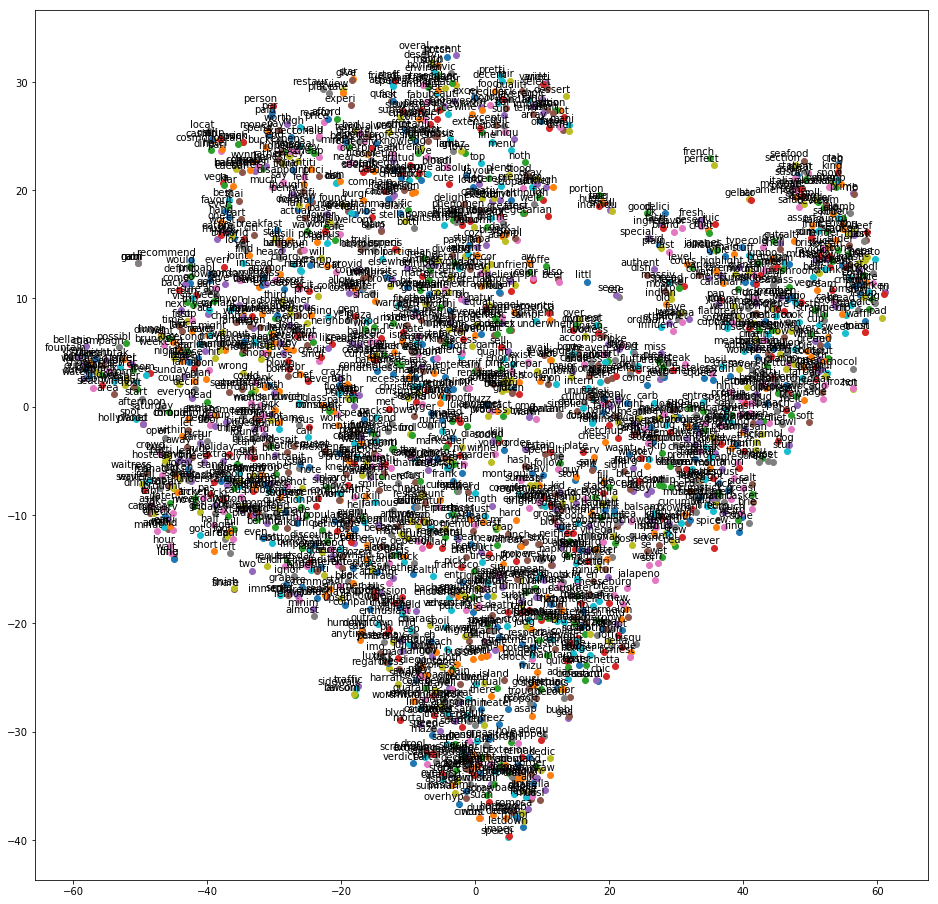

In [33]:
tsne_plot(model)

In [ ]:
# from numpy import array
# from keras.preprocessing.text import one_hot
# from keras.preprocessing.sequence import pad_sequences
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import Flatten
# from keras.layers.embeddings import Embedding
# from sklearn.preprocessing import LabelEncoder
# from keras.utils import np_utils
# from sklearn.model_selection import train_test_split
# # define documents

# # define class labels
# encoder = LabelEncoder()
# encoder.fit(yelp.category)
# encoded_Y = encoder.transform(yelp.category)
# # convert integers to dummy variables (i.e. one hot encoded)
# dummy_y = np_utils.to_categorical(encoded_Y)
# import gensim
# from gensim import corpora
# from gensim.corpora import Dictionary
# dictionary=Dictionary([list(yelp.lemma)])
# # integer encode the documents
# vocab_size = 5248
# #encoded_docs = [one_hot(d, vocab_size) for d in yelp.lemma]
# doc_term_matrix = [dictionary.doc2bow(doc) for doc in yelp.lemma]
# print(doc_term_matrix)
# #print(encoded_docs)
# # pad documents to a max length of 4 words
# max_length = 102
# #padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')


# #X_train, X_test, y_train, y_test = train_test_split(padded_docs,dummy_y,test_size=0.1)

# Lda = gensim.models.ldamodel.LdaModel

# # Running and Trainign LDA model on the document term matrix.
# ldamodel = Lda(doc_term_matrix, num_topics=12, id2word = dictionary, passes=50)

# # evaluate the model
# #y_pred=model.predict(X_test)
# print(ldamodel.print_topics(num_topics=3, num_words=3))

In [ ]:
# from sklearn.metrics import confusion_matrix
# conf_mat = confusion_matrix(y_test, y_pred)
# fig, ax = plt.subplots(figsize=(10,10))
# sns.heatmap(conf_mat, annot=True, fmt='d',
#             xticklabels=category_id_df.category.values, yticklabels=category_id_df.category.values)
# plt.ylabel('Actual')
# plt.xlabel('Predicted')
# plt.show()
loss, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %f' % (accuracy*100))
print('loss: %f' % (loss))

In [ ]:
from sklearn import metrics
#print(metrics.classification_report(y_test, y_pred, target_names=my_df['category'].unique()))
print(metrics.accuracy_score(X_test, y_test))

In [ ]:
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

# Running and Trainign LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=12, id2word = dictionary, passes=50)

In [ ]:
print(y_test[0])

In [ ]:
# from lda2vec import LDA2Vec
# n_words = 10
# n_docs = 15
# n_hidden = 8
# n_topics = 2
# n_obs = 300
# words = np.random.randint(n_words, size=(n_obs))
# _, counts = np.unique(words, return_counts=True)
# model = LDA2Vec(n_words, n_hidden, counts)
# model.add_categorical_feature(n_docs, n_topics, name='document id')
# model.finalize()
# doc_ids = np.arange(n_obs) % n_docs
# loss = model.fit_partial(words, 1.0, categorical_features=doc_ids)